# W261 Final Project

### By Alexander Herring, Jayanth Srinivasa, and Saurav Datta


## 1) Question Formulation

In this final project we seek to perform Click Through Rate (CTR) prediction on a large public dataset of Criteo advertising data.  This data was made available as part of a Kaggle competition several years ago.  CTR is an important and commonly used metric in Internet marketing.  It measures the number of clicks advertisers receive on their ads per number of impressions ((Total Clicks on Ad) / (Total Impressions) = Click Through Rate).  In simple terms, a  high CTR means that a high percentage of people who see an ad click on it.  Thus, ads with a high CTR can be thought of as high performing, and the companies serving these ads can charge more for them.

The winner of the Criteo Kaggle competition achieved a log-loss score of 0.445.  With 718 competition entries, all entries performing above the 90th percentile achieved a log-loss score of 0.46 or less.  While reaching a score this low would be ideal, our model could still be practically useful (especially if it was applied to other datasets) with a slightly higher log-loss score, such as around 0.50.

In pursuit of our ultimate goal of performing CTR prediction on a public dataset of Criteo advertising data, we will perform an exploratory data analysis (EDA), and from this EDA determine if binary logistic regression is an appropriate algorithm to use for CTR prediction.  This will include thoroughly testing its assumptions.  If we determine it is appropriate, we will then apply binary logistic regression to a toy example (an artificial example) to test our general algorithm implementation before applying the same algorithm to a full test and train split.  Our target variable will take a binary value (0 or 1) corresponding whether or not a display ad served was clicked.  We will seek to optimize our implementation of the algorithm to achieve a log-loss score of 0.50 or lower.

As we will explain in more detail in the sections that follow, one limitation of the dataset includes the fact that many of the columns in it are categorical in nature.  To be able to use them with binary logistic regression, which only accepts numerical values, we will have to use a process known as one-hot encoding (OHE) to turn the values in each of the categorical columns into indicator variable.  If we do not do this, we will be unable to use the columns, which would likely lower the predictive power of our model.  We will also go into more depth on other technique used to implement our chosen algrorithm on the toy and Criteo datasets.

## 1.1) Setup

In [3]:
# Installation of necessary packages

# !pip install --upgrade pip
# !pip install --upgrade pandas
# !pip install --upgrade google-api-python-client
# !pip install --upgrade seaborn
# !pip install --upgrade networkx
# !pip install --upgrade matplotlib
# !pip install --upgrade pyspark
# !pip install --upgrade pyspark_dist_explore
# !pip install statsmodels

In [127]:
# Main Imports

from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
#from pyspark.mllib.linalg import VectorUDT
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import SparseVector
from pyspark.sql import functions as F, types
from pyspark.sql.functions import (explode, col)
from pyspark.sql.functions import col, row_number, concat, lit
from pyspark.sql.functions import trim
from pyspark.sql.functions import udf
from pyspark.sql.functions import split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType
from pyspark.sql.types import Row
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

import ast
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import time
import statsmodels.formula.api as smf
import pylab as pl

In [5]:
# To better display plots from matplotlib
%matplotlib inline

In [1]:
# Begin Spark Session - ensure that kernel is PySpark and not Python 2 or Python 3
spark

In [6]:
# Create Spark Context
sc = spark.sparkContext

## 2) EDA & Discussion of Challenges

Before we begin modeling an alogrithm for Click Through Rate prediction, we should first examine the Criteo dataset that we will be using.  To do this, we will examine the initial format and structure of the dataset, the size of the dataset, examine it for missing values and outliers, and capture several summary statistics that will inform us of the distribution of the dataset.  To aid in our analysis, we will plot several graphs that will augment our understanding of the distribution of the dataset.

Furthermore, as mentioned in our question formulation, we would like to use binary logistic regression as the main algorithm in our Click Through Rate prediction.  However, logistic regression models have several assumptions that must be met before they can be used.

The assumptions for logistic regression include:

1)  The outcome is a binary or dichotomous variable (e.g. “yes” or “no”, “positive” or “negative”, 1 or 0).

2)  There is a linear relationship between the logit of the outcome and each predictor variables.  The logit function is $logit(p) = log(p/(1-p))$, where p is the probability of the outcome.

3) Independence of observations.

4) There is no multicollinearity among the independent variables.

5) There are a large number of observations.

Before completing the EDA, we know in advance that the data meets two of the conditions needed for logistic regression.  The target variable of whether or not ad is clicked is binary as it is either a 0 or 1.  Additionally, though it is not explicitly stated, we can assume independence of observations.  Each row in the dataset corresponds to a separately presented display ad, thus making the assumption of independence reasonable.

In the EDA that follows, we will show how the Criteo dataset meets the remaining assumptions necessary for logistic regression, thus allowing us to comfortably use it as our prediction algorithm.

### 2.1) The Dataset is Large and Needs to be Parsed

After loading the data and performing a row count, we can observe that the Criteo dataset is quite large.  It contains 45,840,617 rows (display ads served).  Thus, the assumption needed for logistic regression of using a large number of observations has been met.

Additionally, we can observe that each row in the dataset is initally a single, long string with tab-delimited columns.  These will need to be parsed before any further analysis can be performed.  We wrote code that performs this task, and separates all of these columns into numerical values or strings as appropriate.

In [7]:
rawDF = sqlContext.read.text('gs://w261_final_project_ajh_bucket/data/train.txt').withColumnRenamed("value", "text")
rawDF.cache()
rawDF_count = rawDF.count()
print(rawDF_count)

45840617


In [51]:
rawDF.printSchema()
rawDF.first()

root
 |-- text: string (nullable = true)



Row(text='0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16')

In [46]:
rawDF

DataFrame[text: string]

In [54]:
fullWithColsDF = rawDF.withColumn('tmp', split('text', '\t')).\
                    select( col("tmp").getItem(0).cast("double").alias("label")
                    , col("tmp").getItem(1).cast("double").alias("int_1")
                    , col("tmp").getItem(2).cast("double").alias("int_2")
                    , col("tmp").getItem(3).cast("double").alias("int_3")
                    , col("tmp").getItem(4).cast("double").alias("int_4")
                    , col("tmp").getItem(5).cast("double").alias("int_5")
                    , col("tmp").getItem(6).cast("double").alias("int_6")
                    , col("tmp").getItem(7).cast("double").alias("int_7")
                    , col("tmp").getItem(8).cast("double").alias("int_8")
                    , col("tmp").getItem(9).cast("double").alias("int_9")
                    , col("tmp").getItem(10).cast("double").alias("int_10")
                    , col("tmp").getItem(11).cast("double").alias("int_11")
                    , col("tmp").getItem(12).cast("double").alias("int_12")
                    , col("tmp").getItem(13).cast("double").alias("int_13")
                    , col("tmp").getItem(14).alias("categ_1")
                    , col("tmp").getItem(15).alias("categ_2")
                    , col("tmp").getItem(16).alias("categ_3")
                    , col("tmp").getItem(17).alias("categ_4")
                    , col("tmp").getItem(18).alias("categ_5")
                    , col("tmp").getItem(19).alias("categ_6")
                    , col("tmp").getItem(20).alias("categ_7")
                    , col("tmp").getItem(21).alias("categ_8")
                    , col("tmp").getItem(22).alias("categ_9")
                    , col("tmp").getItem(23).alias("categ_10")
                    , col("tmp").getItem(24).alias("categ_11")
                    , col("tmp").getItem(25).alias("categ_12")
                    , col("tmp").getItem(26).alias("categ_13")
                    , col("tmp").getItem(27).alias("categ_14")
                    , col("tmp").getItem(28).alias("categ_15")
                    , col("tmp").getItem(29).alias("categ_16")
                    , col("tmp").getItem(30).alias("categ_17")
                    , col("tmp").getItem(31).alias("categ_18")
                    , col("tmp").getItem(32).alias("categ_19")
                    , col("tmp").getItem(33).alias("categ_20")
                    , col("tmp").getItem(34).alias("categ_21")
                    , col("tmp").getItem(35).alias("categ_22")
                    , col("tmp").getItem(36).alias("categ_23")
                    , col("tmp").getItem(37).alias("categ_24")
                    , col("tmp").getItem(38).alias("categ_25")
                    , col("tmp").getItem(39).alias("categ_26")
                    ).cache()

### 2.2) 13 Numerical Columns, 26 Categorical Columns

After parsing our data and separating the columns, we can see that there are 13 numerical columns and 26 categorical columns.  The numerical columns appear to be all integer values, while the categorical columns appear to be hash values.

In [128]:
fullWithColsDF.first()

Row(label=0.0, int_1=1.0, int_2=1.0, int_3=5.0, int_4=0.0, int_5=1382.0, int_6=4.0, int_7=15.0, int_8=2.0, int_9=181.0, int_10=1.0, int_11=2.0, int_12=None, int_13=2.0, categ_1='68fd1e64', categ_2='80e26c9b', categ_3='fb936136', categ_4='7b4723c4', categ_5='25c83c98', categ_6='7e0ccccf', categ_7='de7995b8', categ_8='1f89b562', categ_9='a73ee510', categ_10='a8cd5504', categ_11='b2cb9c98', categ_12='37c9c164', categ_13='2824a5f6', categ_14='1adce6ef', categ_15='8ba8b39a', categ_16='891b62e7', categ_17='e5ba7672', categ_18='f54016b9', categ_19='21ddcdc9', categ_20='b1252a9d', categ_21='07b5194c', categ_22='', categ_23='3a171ecb', categ_24='c5c50484', categ_25='e8b83407', categ_26='9727dd16')

### 2.3) Methods for Calculating Statistics

Below are several methods that we use to calculate summary statistics, and perform any necessary transformations.  They include:

1) f_calc_stats, which calculates mean, minimum value, maximum value, standard deviation, variance, skewness of a column in a dataframe.

2) f_check_null, which calculates count of null or NaN or empty for a column.

3) f_display_stats_categ, which calculates count of unique values and empty strings for a column.

4) f_display_stats_int, which calls other functions to get mean, minimum value, maximum value, standard deviation, variance, skewness, and number of nulls/NaN/empty values of a column in a dataframe.

5) f_display_corr, which calculates the correlation and covariance of a variable against the label.

6) f_covert_to_df, which converts an RDD to dataframe.

7) f_cast_str_to_int, which converts integer columns formatted as strings to integers.

8) f_remove_empty_string, which removes rows where at least one column has empty string.

In [72]:
def f_calc_stats(data, column):
    """
    Calculates mean, minimum value, maximum value, standard deviation, variance, skewness of a column in a dataframe.
    Returns a list containing mean, minimum value, maximum value, standard deviation, variance, skewness
    Arguments:
        data         - dataframe on which we are calculating statistics.
        column       - column for which statistics have to be calculated
    Returns:
        A list containing the mean, minimum value, maximum value, standard deviation, variance, skewness of the column.
    """
    return data.agg(F.avg(data[column]), F.min(data[column]), F.max(data[column]),
                    F.stddev_pop(data[column]),F.var_pop(data[column]),F.skewness(data[column])
                   ).collect()

In [73]:
def f_check_null(data, column):
    """
    Calculates count of null or NaN or empty for a column.
    Returns an integer for the count  of null or NaN or empty for a column.
    Arguments:
        data         - dataframe on which we are calculating the metric.
        column       - column for which the metric has to be calculated.
    Returns:
        An integer for the count where the column is null or NaN or empty.
    """
    return data.filter( (data[column] =="") |F.isnull(data[column])|F.isnan(data[column])
                      ).count()

In [74]:
# Checking cardinality
def f_display_stats_categ(df, inColList):
    """
    Calculates count of unique values and empty strings for a column.
    Displays the output as a HTML table.
    Arguments:
        df         - dataframe on which we are calculating the metric.
        inColList  - list of column names for which we are calculating the metrics.
    Returns:
        Displays the output as a HTML table.
    """
    dict1={}
    for col in inColList:
        cardinal_cnt = df.select([col]).distinct().count()
        dict1[col]={"Count_Unique_Vals":cardinal_cnt}
        dict1[col]['Count_Empty_String'] = str(df.filter(df[col] == "").count())

    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [75]:
def f_display_stats_int(data):
    """
    Calls other functions to get mean, minimum value, maximum value, standard deviation, variance, skewness, number of nulls/NaN/empty values of a column in a dataframe..
    Displays the output as a HTML table.
    Arguments:
        df         - dataframe on which we are calculating the metric.
        inColList  - list of column names for which we are calculating the metrics.
    Returns:
        Displays the output as a HTML table.
    """
    dict1={}
    countTotal = data.count()
    for colname in [item[0] for item in data.dtypes if item[1].startswith('double')]:
        list1=f_calc_stats(data,colname)
        mean_val, min_val,max_val,stddev,var, skewness =list1[0]
        count_nulls = f_check_null(data,colname)
        dict1[colname]={}
        dict1[colname]['mean'] = str(round(mean_val,2))
        dict1[colname]['min'] = str(min_val)
        dict1[colname]['max'] = str(max_val)
        dict1[colname]['stddev'] = str(round(stddev,2))
        dict1[colname]['var'] = str(round(var,2))
        dict1[colname]['skewness'] = str(round(skewness,2))
        dict1[colname]['nulls_nans'] = str(count_nulls)
        dict1[colname]['pct_nulls_nans'] = str(round(float(count_nulls/countTotal*100),2))
        dict1[colname]['count_empty_string'] = str(data.filter(data[colname] == "").count())
        dict1[colname]['count_unique_values'] = str(data.select([colname]).distinct().count())
   #Transposing dataframe to keep column names as rows
    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [76]:
def f_display_corr(df, int_col_list):
    """
    Calculates the correlation and covariance of a variable against the label
    Arguments:
        df         - dataframe on which we are calculating the metric.
        inColList  - list of numeric column names for which we are calculating covariance and correlation.
    Returns:
        Displays the correlation and covariance as a HTML table.
    """
    sampleDF=df.sample(seed=1, fraction=0.5, withReplacement=False)
    dict1={}
    for col in int_col_list:
        corr = df.stat.corr('label',col)
        cov = df.stat.cov('label',col)
        dict1[col]={}
        dict1[col]["Corr"]=corr
        dict1[col]["Cov"]=cov
    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [77]:
# Create dataframe from RDD
def f_covert_to_df(rdd, col_list):
    """
    Converts a RDD to dataframe
    Arguments:
        rdd         - RDD to convert to dataframe.
        col_list    - list of columns representing the schema.
    Returns:
        A dataframe.
    """
    return rdd.map(lambda x: x.split('\t')).toDF(col_list)

In [129]:
# Convert integer columns to IntegerType from String
def f_cast_str_to_int(df, integer_col_list):
    """
    Convers integer columns formatted as strings to integers.
    Arguments:
        df         - dataframe on which we are calculating the metric.
        integer_col_list    - list of columns representing the integer columns in the schema.
    Returns:
        A dataframe.
    """
    for col in integer_col_list:
        df = df.withColumn(col, df[col].cast(types.IntegerType()))
    return df

In [130]:
# Removes rows where at least one column has empty string
def f_remove_empty_string(df, categ_col_list):
    """
    Removes rows where at least one column has empty string
    Arguments:
        df         - dataframe on which we are calculating the metric.
        col_list    - list of columns representing the schema.
    Returns:
        A dataframe.
    """
    for categ_col in categ_col_list:
        df = df.filter(df[categ_col] != "")
    return df

### 2.4) Summary Statistics

Below we generate summary statistics for our full dataset, which again is rather large at 45,840,617 rows / records.

#### Numerical Columns

For our 13 numerical columns, we can observe that for many of the columns there are a substantial number of null / not-a-number (nan) values.  There are many columns for which this is around 20%, though the number reaches as high  as 76.5% for the column "int_12".  It should be noted that for the "int_1" column there are no null / nan values.

The values in the numerical columns vary greatly in size and often in range.  For example, column int_11 has a mean value of 0.62, while column int_5 has a mean value of 18538.99, and ranges in value from 0 to 23,159,456.0.   This wide range for column int_5 suggests that it may have a number of outliers, which we will explore further graphically.

Additionally, our target variable (denoted here as "label") shows that on average there is a 26% click-through rate in the Criteo data, which can be seen as the mean of the column given that the column can only take on binary values (0 or 1).  Once again, the fact that the target variable is binary allows the dataset to meet a condition necessary to use logistic regression.

Furthermore, some columns, in particular "int_5", exhibit very high skewness and variance.  We will explore this further graphically.

#### Categorical Columns

For our 26 categorical columns, about half of them have no empty string / null values, while the other half contain a large amount.  This reaches as high as 34,955,073 empty string / null values for "categ_22".  Interesting is that many of the columns with higher number of unique values also have high numbers of empty string / null values.

In [137]:
print(rawDF_count)

45840617


In [144]:
labelColList=["label"]
intColList=["int_1", "int_2", "int_3", "int_4", "int_5", "int_6", "int_7"\
            , "int_8", "int_9", "int_10", "int_11", "int_12", "int_13"]
categColList=["categ_1", "categ_2", "categ_3", "categ_4", "categ_5", "categ_6"\
              , "categ_7", "categ_8", "categ_9", "categ_10", "categ_11", "categ_12"\
              , "categ_13", "categ_14", "categ_15", "categ_16", "categ_17", "categ_18"\
              , "categ_19", "categ_20", "categ_21", "categ_22", "categ_23", "categ_24", "categ_25", "categ_26"]

In [132]:
print("Summary statistics for numerical and categorical columns")
f_display_stats_int(fullWithColsDF)
f_display_stats_categ(fullWithColsDF, categColList)

Summary statistics for numerical and categorical columns


,count_empty_string,count_unique_values,max,mean,min,nulls_nans,pct_nulls_nans,skewness,stddev,var
label,0,2,1.0,0.26,0.0,0,0.0,1.12,0.44,0.19
int_1,0,649,5775.0,3.5,0.0,20793556,45.36,27.88,9.43,88.91
int_2,0,9364,257675.0,105.85,-3.0,0,0.0,13.2,391.46,153239.22
int_3,0,14746,65535.0,26.91,0.0,9839447,21.46,81.49,397.97,158382.17
int_4,0,490,969.0,7.32,0.0,9937369,21.68,4.09,8.79,77.32
int_5,0,476707,23159456.0,18538.99,0.0,1183117,2.58,10.1,69394.6,4815610657.56
int_6,0,11618,431037.0,116.06,0.0,10252328,22.37,184.98,382.57,146357.08
int_7,0,4142,56311.0,16.33,0.0,1982866,4.33,46.39,66.05,4362.57
int_8,0,1373,6047.0,12.52,0.0,22773,0.05,66.16,16.69,278.52
int_9,0,7275,29019.0,106.11,0.0,1982866,4.33,8.52,220.28,48524.64


,Count_Empty_String,Count_Unique_Vals
categ_1,0,1460
categ_2,0,583
categ_3,1559473,10131227
categ_4,1559473,2202608
categ_5,0,305
categ_6,5540625,24
categ_7,0,12517
categ_8,0,633
categ_9,0,3
categ_10,0,93145


### 2.5) Lack of Correlation and Lack of Multicollinearity

As we can see below, there is at best weak correlation of the numerical columns with the target variable.  Column int_10 has the highest correlation at 0.19, which is still fairly weak.  In terms of negative correlation, the lowest correlation is 0.08 for columns int_5 and int_13, which is also very weak.

Furthermore, in the correlation matrix below we can see that there is a lack of notable multicollineraity of the columns with each other.  The majority of the values in the correlation matrix are between 0.20 and 0.30.  There are many values close to 0, though there are a handful of values as high as 0.61 (between int_04 and int_13), and 0.69 (between int_07 and int_11).  While these two columns have the highest risk of multicollinearity, which would potentially bias the data, this correlation is not strong.  We have also presented a correlation matrix heatmap to more easily visualize the covariances.

Overall, our dataset can be said to not have multicollinearity, and thus meets this condition for logistic regression.

In [133]:
print("Correlation and Covariance w.r.t target field")
f_display_corr(fullWithColsDF, intColList)

Correlation and Covariance w.r.t target field


,Corr,Cov
int_1,0.104088,0.326463
int_2,0.044435,7.593410
int_3,0.009770,1.505005
int_4,-0.055718,-0.203014
int_5,-0.076539,-2290.654047
int_6,-0.055812,-8.296949
int_7,0.085156,2.404850
int_8,-0.027436,-0.199864
int_9,0.024072,2.275556
int_10,0.191717,0.049527


In [145]:
# Select only numerical columns
fullWithColsDF_int = fullWithColsDF.select(intColList)

In [153]:
correlation_df = fullWithColsDF_int.na.fill(0)

# Convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=correlation_df.columns, outputCol=vector_col)
df_vector = assembler.transform(correlation_df).select(vector_col)

# Get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [183]:
# intColList_ex = intColList=["int_01", "int_02", "int_03", "int_04", "int_05", "int_06", "int_07", "int_08", "int_09", "int_10", "int_11", "int_12", "int_13"]

correlation_matrix = pd.DataFrame(matrix.collect()[0]["pearson({})".format(vector_col)].values)
correlation_matrix = correlation_matrix.values.reshape(13, 13)
correlation_matrix = pd.DataFrame(correlation_matrix, columns = intColList_ex, index = intColList_ex)
print("Correlation Matrix")
correlation_matrix

Correlation Matrix


,int_01,int_02,int_03,int_04,int_05,int_06,int_07,int_08,int_09,int_10,int_11,int_12,int_13
int_01,1.000000,0.034108,0.038390,0.081069,-0.068993,-0.058315,0.477780,0.097048,0.068316,0.465176,0.304534,0.092164,0.005279
int_02,0.034108,1.000000,-0.008308,-0.081530,-0.006260,-0.013320,0.025422,-0.028035,-0.004732,0.035712,0.032760,-0.001294,-0.034543
int_03,0.038390,-0.008308,1.000000,0.042022,-0.003412,0.005079,0.000373,0.045087,-0.000465,-0.003791,-0.005823,-0.001431,0.030109
int_04,0.081069,-0.081530,0.042022,1.000000,-0.094468,0.015560,0.038521,0.504384,0.194364,0.157900,0.063999,0.021092,0.612960
int_05,-0.068993,-0.006260,-0.003412,-0.094468,1.000000,0.002158,-0.056270,-0.109468,-0.068310,-0.148043,-0.115582,-0.020923,-0.054280
int_06,-0.058315,-0.013320,0.005079,0.015560,0.002158,1.000000,-0.027060,0.022175,0.186576,-0.124605,-0.039072,-0.012915,0.045574
int_07,0.477780,0.025422,0.000373,0.038521,-0.056270,-0.027060,1.000000,0.077122,0.233840,0.251448,0.685523,0.093341,0.003478
int_08,0.097048,-0.028035,0.045087,0.504384,-0.109468,0.022175,0.077122,1.000000,0.206472,0.156661,0.139375,0.028334,0.631302
int_09,0.068316,-0.004732,-0.000465,0.194364,-0.068310,0.186576,0.233840,0.206472,1.000000,0.075001,0.403943,0.045726,0.192788
int_10,0.465176,0.035712,-0.003791,0.157900,-0.148043,-0.124605,0.251448,0.156661,0.075001,1.000000,0.386369,0.084908,0.023659


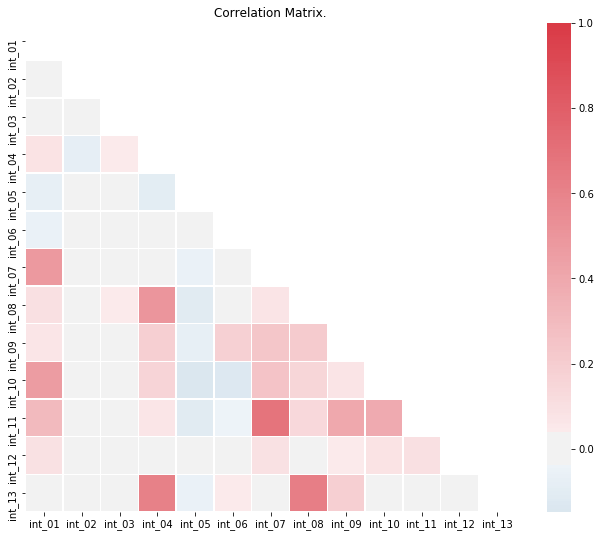

In [182]:
# Heatmap for correlations matrix
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlation Matrix.")
plt.show()

### 2.6) Histograms on Data Subset

Below we show several histograms of the numerical columns to better observe their distributions.  Due to the inefficiency with which Spark plots graphs, we are using a 0.01% subset of the data for our graphs, which represents 4,635 rows.

Virtually all of the columns have a large number of values of 0.  This raises the concern that the data in the numerical columns may not be as useful as we would like, as if many of the values in the columns are identical (at 0) they may lack predictive power.  All of the columns are also heavily right-skewed, likely due to the large numer of 0 values.  However, the presence of a large number of 0 values makes the dataset ideal for sparse representation, which we will discuss further in our "Algorithm Explanation" section.

Additionally, as seen earlier when numerically observing the range of values, many columns appear to have outliers.  This occurs most notably with columns int_5 and int_3.  These outliers run the risk of inordinately influencing our alogrithm, thus lowering its predictive power.

In [168]:
sample_df = fullWithColsDF.sample(False, fraction=0.0001, seed = 1)
sample_df.cache()

DataFrame[label: double, int_1: double, int_2: double, int_3: double, int_4: double, int_5: double, int_6: double, int_7: double, int_8: double, int_9: double, int_10: double, int_11: double, int_12: double, int_13: double, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [169]:
sample_df.count()

4635

In [170]:
#Convert to Pandas DataFrame
pd_sample_df = sample_df.toPandas()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d01e2c320>,
      dtype=object)

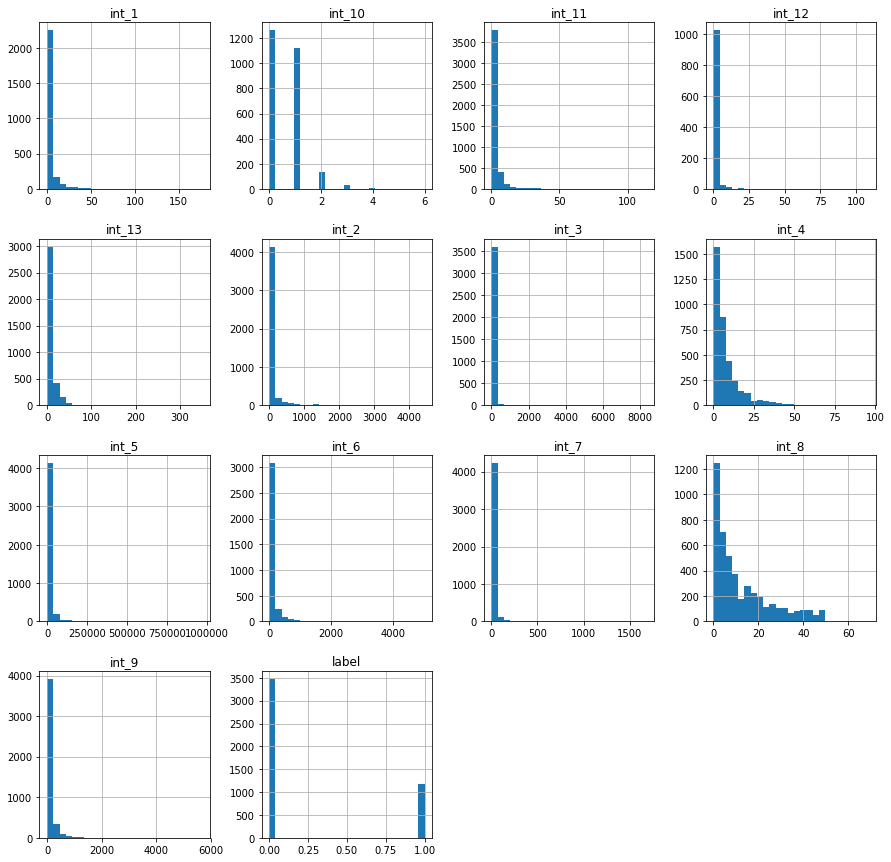

In [199]:
pd_sample_df.hist(figsize = (15, 15), bins = 25)

### 2.7) Graphs of Log-Odds - Final Logistic Regression Assumption Met

We have one more assumption of logistic regression to test - that there is a linear relationship between the logit of the outcome and each predictor variable.  Again, the logit function is $logit(p) = log(p/(1-p))$ where p is the probability of the outcome.

To save space, below we only plot the relationship between the logit of the outcome and the predictor variable "int_1".  However, this and the other numerical variables all show that this relationshp is linear.  For "int_1", this can be seen by the characteristic "S" shaped of the curve that has been generated by the sigmoid function.

Thus, our final assumption needed for logstic regression has been met, and we can move on to implementation of the algrorithm.

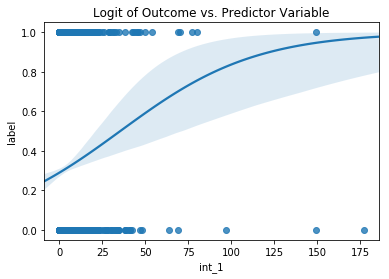

In [205]:
log_plot_1 = sns.regplot(x = 'int_1', y = 'label', data= pd_sample_df, logistic= True).\
                set_title("Logit of Outcome vs. Predictor Variable")

## 3) Algorithm Explanation - With Toy Example

As we have shown that we have met all the assumptions for logistic regression, we will proceed to use it for our Click Through Rate prediction task.

Before we perform the prediction on the Criteo dataset, we will begin by explaining the methodology behind how to apply linear regression to a toy (small and artifical) dataset that has a binary target variable and a mix of numerical and categorical columns.  Our methodolgy will include the use of one-hot encoding (OHE), sparse vectors, and gradient descent.  We will also explore some of the math behind logistic regression, including the use of a sigmoid function.

For our toy example, we decided to measure the dropout rate for undergraduate students at Berkeley.  Please note that our data is completely randomly generated.  We created 1,000 records to obtain a large enough dataset for use with linear regression.  In addition to our target variable for drop_out (1 if a student drops out, 0 if they do not), our columns in order are terms taken, average partcipation rating (an average score from 0 to 10 assigned by professors), GPA, an indicator variable for whether the student is an in-state student or not, the major, and the minor.  The major and minor are categorical variables.  Below you can see some sample rows of our dataset.

In [178]:
toy_rawDF = sqlContext.read.text('gs://w261_final_project_ajh_bucket/data/Toy_Example_Data.csv').withColumnRenamed("value", "text")
toy_rawDF.head(5)

[Row(text='1,4,6.37,2.85,0,Astrophysics,French'),
 Row(text='1,5,7.84,3.91,1,Sports Management,Data Science'),
 Row(text='1,2,5.5,2.82,1,Statistics,Computer Science'),
 Row(text='1,3,8.43,1.92,1,English,Religious Studies'),
 Row(text='0,4,6.29,3.43,1,Fine Arts,Data Science')]

### 3.1) Parsing

We begin by parsing our data into a usable format with the parse_point_toy function, before converting it to a DataFrame with the parse_toy_raw_df function.

In [95]:
def parse_point_toy(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.
    Note:
        featureIDs should start at 0 and increase to the number of features - 1.
    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
    Returns:
        list: A list of (featureID, value) tuples.
    """
    values = point.split(',')[1:]
    #values = filter(None, values)
    indices = range(len(values))
    return zip(indices,values)

In [96]:
from pyspark.sql.functions import udf, split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType, FloatType, DoubleType

parse_point_toy_udf = udf(parse_point_toy, ArrayType(StructType([StructField('_1', LongType()),StructField('_2', StringType())])))

def parse_toy_raw_df(raw_df):
    """Convert a DataFrame consisting of rows of comma separated text into labels and feature.
    Args:
        raw_df: DataFrame containing the raw comma separated data.
    Returns:
        DataFrame: A DataFrame with 'label' and 'feature' columns.   
    """
    return (raw_df.select(split(raw_df.text,',').getItem(0).cast("double").alias('label'),
                         parse_point_toy_udf(raw_df.text).alias('features'))
                        .cache())

### 3.2) One-Hot Encoding with Sparse Representation

To account for the categorical columns in our toy dataset (major and minor), we will use one-hot encoding (OHE).  One-hot encoding is used to represent categorical variables (which are often non-numeric) as binary vectors / values.  One-hot encoding is necessary as machine learning algorithms, including linear regression, cannot directly work with categorical data.  When implementing one-hot encoding in lists or dataframes, every label that is observed for a category is used to create additional columns.  Any time one of these labels is observed for a record, a “1” will be entered into the corresponding column.  If a label is not observed for a record, a “0” will be entered into the corresponding column.  For example, the major "Data Science" becomes a new column that supports binary values, as does the minor "French".

To perform one-hot encoding on our data, we use the functions toy_create_one_hot_dict (creates a one-hot-encoder dictionary based on the input data), toy_ohe_udf_generator (generates a user-defined function that is set-up to one-hot-encode rows with the given dictionary), and toy_one_hot_encoding (produces a one-hot-encoding from a list of features and an OHE dictionary).  

Important to note is that the toy_one_hot_encoding function creates a sparse matrix representation, which is important for scalability and memory utilization concerns.  Sparse matrices and vectors are most useful when a large number of values in a dataset are 0.  As shown in our EDA, the Criteo dataset contains a large proporion of values of 0, thus making it ideal for sparse representation.  Sparse representation of matrices and vectors acts as a form of compression, where much of the space that would have been used to store values of 0 in a dense representation is saved.  Sparse representation often runs much faster than dense representation, which is important for large datasets such as the Criteo dataset.

In [97]:
def toy_create_one_hot_dict(input_df):
    """Creates a one-hot-encoder dictionary based on the input data.
    Args:
        input_df (DataFrame with 'features' column): A DataFrame where each row contains a list of
            (featureID, value) tuples.
    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    input_distinct_feats_df = input_df.select(explode(input_df.features)).distinct()
    input_ohe_dict = (input_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex().collectAsMap())
    return input_ohe_dict

In [98]:
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import VectorUDT

def toy_ohe_udf_generator(ohe_dict_broadcast):
    """Generate a UDF that is set-up to one-hot-encode rows with the given dictionary.
    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the toy_one_hot_encoding function.
    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the toy_one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: toy_one_hot_encoding(x, ohe_dict_broadcast, length), VectorUDT())

In [99]:
from pyspark.mllib.linalg import SparseVector
def toy_one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produces a one-hot-encoding from a list of features and an OHE dictionary.
    Note:
        You should ensure that the indices used to create a SparseVector are sorted.
    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).
    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats])
    values = np.ones(len(raw_feats))
    return SparseVector(num_ohe_feats,indices,values)

### 3.3) Logistic Regression with Gradient Descent

After performing the one-hot encoding, we split our dataset into train, test, and dev sets that comprise 80%, 10%, and 10% of the rows, respectively.

#### Logistic Regression

At this point, we're ready to begin implementing our binary logistic regression algorithm.  Logistic regression relies on transforming a dataset using a sigmoid function.  This transformation gives the data in logistic regression an "S" shaped curve, and forces values to be between 0 and 1.  The equation for the sigmoid is:

$$ f (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^-(x) }  $$ 

#### Log-Loss

Log-loss (related to cross-entropy) measures the performance of a classification model where the prediction input is a probability value between 0 and 1.  It represents a common cost, or loss function, used with logistic regression. A primary goal of the algorithm we are implementing is to minimize the log-loss value. A perfect model would have a log loss of 0. Log loss increases as the predicted probability diverges from the actual label.  The equation for log-loss is:

For a single sample with true label $y_t$ in {0,1} and estimated probability $y_p$ that $y_t$ = 1, the log loss is

$-log(P(y_t|y_p)) = -(y_t log(y_p) + (1 - y_t) log(1 - y_p))$

#### Gradient Descent in Logistic Regression

In order to implement our logistric regression algorithm in a scalable and computationally efficient manner, we chose to use gradient descent in our approach.  Gradient Descent is a process that works iteratively to find the optimal parameters for a model when fed a particular training data set. It does this by using the vector of partial derivatives of a loss function to strategically update parameters in a way that will reduce the loss.  As mentioned before, in the case of our logistic regression algorithm, the loss function being optimized is the log-loss function.  The hypothesis function for the method of gradient descent used in logistic regression is as follows:

$$\theta_j  = \frac{1}{m} \sum_{i=1}^m Cost(h_{\theta} (\pmb{x}^{(i)}), y^{(i)})$$

Where $Cost(h_{\theta}(x),y) ={−log(h_{\theta}(x))}$ if y = 1 and

$Cost(h_{\theta}(x),y) ={−log(h_{\theta}(1 - x))}$ if y = 0

and where $h_{\theta}$ is a hypothesis of the optimal value.

#### Logistic Regression in the Toy Example

To implement logistic regression in our toy example, we used the functions sigmoid (to generate a sigmoid transformation), GradientDescent (to implement Gradient Descent), LogLoss (to calculate log-loss), GDUpdate(to perform one step/update on the logistic regression).  Worth noting is that after performing One-Hot Encoding, we generated 682 features for inclusion in our logistic regression model.

In [206]:
weights = [0.8, 0.1, 0.1]
seed = 42
# Use randomSplit with weights and seed
raw_toy_train_df, raw_toy_validation_df, raw_toy_test_df = toy_rawDF.randomSplit(weights, seed)

# Cache and count the DataFrames
n_toy_train = raw_toy_train_df.cache().count()
n_toy_val = raw_toy_validation_df.cache().count()
n_toy_test = raw_toy_test_df.cache().count()
print("Train, dev, test, and total row counts")
print(n_toy_train, n_toy_val, n_toy_test, str(n_toy_train + n_toy_val + n_toy_test))

Train, dev, test, and total row counts
806 94 100 1000


In [103]:
parsed_toy_train_df = parse_toy_raw_df(raw_toy_train_df)
print(parsed_toy_train_df.head())

Row(label=0.0, features=[Row(_1=0, _2='2'), Row(_1=1, _2='5.01'), Row(_1=2, _2='2.41'), Row(_1=3, _2='1'), Row(_1=4, _2='Math'), Row(_1=5, _2='German')])


In [104]:
from pyspark.sql.functions import (explode, col)
num_toy_categories = (parsed_toy_train_df
                    .select(explode('features').alias('features'))
                    .distinct()
                    .select(col('features').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())

In [105]:
print(num_toy_categories)

[Row(featureNumber=0, sum(featureNumber)=0), Row(featureNumber=1, sum(featureNumber)=402), Row(featureNumber=2, sum(featureNumber)=480), Row(featureNumber=3, sum(featureNumber)=6), Row(featureNumber=4, sum(featureNumber)=68), Row(featureNumber=5, sum(featureNumber)=85)]


In [209]:
toy_ohe_dict = toy_create_one_hot_dict(parsed_toy_train_df)
num_toy_ohe_feats = len(toy_ohe_dict)
print("Number of OHE Features Generated")
print(num_toy_ohe_feats)

Number of OHE Features Generated
682


682

In [211]:
toy_ohe_dict_broadcast = sc.broadcast(toy_ohe_dict)
toy_ohe_dict_udf =  toy_ohe_udf_generator(toy_ohe_dict_broadcast)
toy_ohe_train_df =  parsed_toy_train_df.select(toy_ohe_dict_udf(parsed_toy_train_df.features).alias('features'),parsed_toy_train_df.label,)

# print(toy_ohe_train_df.count())
# print(toy_ohe_train_df.show())
# print(toy_ohe_train_df.take(1))

In [108]:
toy_ohe_train_rdd = toy_ohe_train_df \
                     .rdd \
                     .cache()

In [109]:
meanDropOut = toy_ohe_train_rdd.map(lambda x: x[1]).mean()
varDropOut = toy_ohe_train_rdd.map(lambda x: x[1]).variance()
numDropOut = toy_ohe_train_rdd.map(lambda x: x[1]).sum()/toy_ohe_train_df.count()
print(f"PercentDropOut: {numDropOut}")
print(f"Mean: {meanDropOut}")
print(f"Variance: {varDropOut}")

PercentDropOut: 0.6625310173697271
Mean: 0.6625310173697274
Variance: 0.2235836683927612


In [110]:
BASELINE = np.append(meanDropOut, np.zeros(num_toy_ohe_feats))

In [111]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [116]:
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.01, verbose = False):
    """
    Perform nSteps iterations of gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        model = GDUpdate(trainRDD, model, learningRate)
        training_loss = LogLoss(trainRDD, model) 
        test_loss = LogLoss(testRDD, model)
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [114]:
def LogLoss(dataRDD, W):
    """
    Compute log loss.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    loss = augmentedData.map(lambda x: (-x[1] * np.log(sigmoid(W.dot(x[0]))) \
                                     - (1 - x[1]) * np.log(1 - sigmoid(W.dot(x[0])))) ).mean()
    return loss

In [208]:
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one step/update on the Logistic regression.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    grad = augmentedData.map(lambda x: np.dot(sigmoid(W.dot(x[0]) - x[1]),x[0])).mean()
    new_model = W - learningRate * grad
    
    return new_model

### 3.4) Algorithm Performance for Toy Example

After implementing several functions to transform our data and run our algorithm, we obtain a log-loss score of 0.6625 on our toy training dataset, and a very similar log-loss score of 0.6618 on our toy test dataset.  Ideally, we will be able to beat this when we run our logistic regression implementation on the Criteo dataset.

In [118]:
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {LogLoss(toy_ohe_train_rdd,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(toy_ohe_train_rdd, model)
    loss = LogLoss(toy_ohe_train_rdd, model)
    print(f"Loss: {loss}")
  #  print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.6393586657271466
----------
STEP: 1
Loss: 0.6405834992567013
----------
STEP: 2
Loss: 0.643721487215732
----------
STEP: 3
Loss: 0.6485545689963543
----------
STEP: 4
Loss: 0.6548778151932536
----------
STEP: 5
Loss: 0.6625012704436208


In [123]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = toy_ohe_train_rdd.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
train, test, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 622.8087210655212 seconds


In [119]:
# Additional functions used for transforming the test split
def toy_one_hot_encoding_v2(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.
    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).
    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats if feat in ohe_dict_broadcast.value])
    values = np.ones(len([feat for feat in raw_feats if feat in ohe_dict_broadcast.value] ))
    return SparseVector(num_ohe_feats,indices,values)

def toy_ohe_udf_generator_v2(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.
    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.
    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: toy_one_hot_encoding_v2(x, ohe_dict_broadcast, length), VectorUDT())

In [210]:
#test
toy_ohe_dict_missing_udf = toy_ohe_udf_generator_v2(toy_ohe_dict_broadcast)

toy_ohe_test_df = parsed_toy_train_df.select(toy_ohe_dict_missing_udf(parsed_toy_train_df.features).alias('features'), parsed_toy_train_df.label,).cache()
# print(toy_ohe_test_df.count())
# print(toy_ohe_test_df.show())
# print(toy_ohe_test_df.take(1))

In [121]:
toy_ohe_test_rdd = toy_ohe_test_df \
                     .rdd \
                     .cache()

In [124]:
#MSE = LogLoss(ohe_test_rdd, models)
toy_train_model = np.asarray(models[-1])
LogLoss(toy_ohe_test_rdd, toy_train_model)

0.6617741806149889

## 4) Algorithm Implementation

After demonstrating our methodolgy for implementing binary logistic regression on our toy dataset, we are ready to implement it on the Criteo dataset.

We begin by creating a train, dev, and test split of the Criteo day.  We additionally ensure the column transformations used in the EDA are applied to the data to properly cast the numerical columns as numbers ("doubles") and separate the categorical columns.  Please note that for performance purposes we chose to run the majority of our model on 25% of the train set.  This still provide a wealth of data, with 9,167,896 rows.

In [20]:
weights = [0.8, 0.1, 0.1]
seed = 1

# Use randomSplit with weights and seed
rawTrainDF, rawValidationDF, rawTestDF = rawDF.randomSplit(weights, seed)

In [21]:
#25% sampling due to memory errors
rawTrainNewDF = rawTrainDF.sample(withReplacement=False, fraction=0.25, seed=1)

In [22]:
rawTrainNewDF.cache()
rawValidationDF.cache()
rawTestDF.cache()

DataFrame[text: string]

In [23]:
rawTrainNewDF.count()

9167896

In [ ]:
trainWithColsDF = rawTrainNewDF.withColumn('tmp', split('text', '\t')).\
                    select( col("tmp").getItem(0).cast("double").alias("label")
                    , col("tmp").getItem(1).cast("double").alias("int_1")
                    , col("tmp").getItem(2).cast("double").alias("int_2")
                    , col("tmp").getItem(3).cast("double").alias("int_3")
                    , col("tmp").getItem(4).cast("double").alias("int_4")
                    , col("tmp").getItem(5).cast("double").alias("int_5")
                    , col("tmp").getItem(6).cast("double").alias("int_6")
                    , col("tmp").getItem(7).cast("double").alias("int_7")
                    , col("tmp").getItem(8).cast("double").alias("int_8")
                    , col("tmp").getItem(9).cast("double").alias("int_9")
                    , col("tmp").getItem(10).cast("double").alias("int_10")
                    , col("tmp").getItem(11).cast("double").alias("int_11")
                    , col("tmp").getItem(12).cast("double").alias("int_12")
                    , col("tmp").getItem(13).cast("double").alias("int_13")
                    , col("tmp").getItem(14).alias("categ_1")
                    , col("tmp").getItem(15).alias("categ_2")
                    , col("tmp").getItem(16).alias("categ_3")
                    , col("tmp").getItem(17).alias("categ_4")
                    , col("tmp").getItem(18).alias("categ_5")
                    , col("tmp").getItem(19).alias("categ_6")
                    , col("tmp").getItem(20).alias("categ_7")
                    , col("tmp").getItem(21).alias("categ_8")
                    , col("tmp").getItem(22).alias("categ_9")
                    , col("tmp").getItem(23).alias("categ_10")
                    , col("tmp").getItem(24).alias("categ_11")
                    , col("tmp").getItem(25).alias("categ_12")
                    , col("tmp").getItem(26).alias("categ_13")
                    , col("tmp").getItem(27).alias("categ_14")
                    , col("tmp").getItem(28).alias("categ_15")
                    , col("tmp").getItem(29).alias("categ_16")
                    , col("tmp").getItem(30).alias("categ_17")
                    , col("tmp").getItem(31).alias("categ_18")
                    , col("tmp").getItem(32).alias("categ_19")
                    , col("tmp").getItem(33).alias("categ_20")
                    , col("tmp").getItem(34).alias("categ_21")
                    , col("tmp").getItem(35).alias("categ_22")
                    , col("tmp").getItem(36).alias("categ_23")
                    , col("tmp").getItem(37).alias("categ_24")
                    , col("tmp").getItem(38).alias("categ_25")
                    , col("tmp").getItem(39).alias("categ_26")
                    ).cache()

### 4.1) Function Application

For the application of our binary logistic regression algorithm to the Criteo dataset, we will utilize functions similar to those used for the toy example.  They include one_hot_encoding (produces a one-hot encoding from a list of features and an OHE dictionary), ohe_udf_generator (generates a user defined function that is set-up to one-hot encode rows with the given dictionary), create_one_hot_dict (creates a one-hot encoder dictionary based on the input data), parse_point(for parsing CSV data), and parse_raw_df(to transform a DataFrame into labels and features).

In [34]:
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produces a one-hot-encoding from a list of features and an OHE dictionary.
    Note:
        You should ensure that the indices used to create a SparseVector are sorted, and that the
        function handles missing features.
    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).
    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    #indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats if feat in ohe_dict_broadcast.value])
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats])
    values = np.ones(len(raw_feats))
    return SparseVector(num_ohe_feats,indices,values)

In [35]:
def ohe_udf_generator(ohe_dict_broadcast):
    """Generates a UDF that is set-up to one-hot encode rows with the given dictionary.
    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.
    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: one_hot_encoding(x, ohe_dict_broadcast, length), VectorUDT())

In [36]:
def create_one_hot_dict(input_df):
    """Creates a one-hot-encoder dictionary based on the input data.
    Args:
        input_df (DataFrame with 'features' column): A DataFrame where each row contains a list of
            (featureID, value) tuples.
    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    input_distinct_feats_df = input_df.select(explode(input_df.features)).distinct()
    input_ohe_dict = (input_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex().collectAsMap())
    return input_ohe_dict

In [125]:
def parse_point(point):
    """ Converts a tab separated string into a list of (featureID, value) tuples.
    Note:
        featureIDs should start at 0 and increase to the number of features - 1.
    Arguments:
        point (str): A tab separated string where the first value is the label and the rest
            are features.
    Returns:
        list: A list of (featureID, value) tuples.
    """
    values = point.split('\t')[1:]
    indices = range(len(values))
    return zip(indices,values)

In [126]:
parse_point_udf = udf(parse_point, ArrayType(StructType([StructField('_1', LongType()),StructField('_2', StringType())])))

def parse_raw_df(raw_df):
    """ Will transform a DataFrame with tab separated text into labels and features.
    Arguments:
        raw_df (DataFrame with a 'text' column): DataFrame containing the raw tab separated data.
    Returns:
        DataFrame: A DataFrame with 'label' and 'feature' columns.   
    """
    return (raw_df.select(split(raw_df.text,'\t').getItem(0).cast("double").alias('label'),
                         parse_point_udf(raw_df.text).alias('features'))
                        .cache())

In [37]:
parsed_train_df = parse_raw_df(rawTrainNewDF)
parsed_validation_df = parse_raw_df(rawValidationDF)
parsed_test_df = parse_raw_df(rawTestDF)

In [38]:
parsed_train_df.cache()
parsed_validation_df.cache()
parsed_test_df.cache()

DataFrame[label: double, features: array<struct<_1:bigint,_2:string>>]

In [41]:
num_categories = (parsed_train_df
                    .select(explode('features').alias('features'))
                    .distinct()
                    .select(col('features').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())

### 4.2) One-Hot Encoding Application

In the next few cells you can observe how we create our one-hot encoding dictionary using the create_one_hot_dict function.  It ends up producing a large number of features: 9,444,472!

Next, to handle features seen in the test split but not the training split, we employ the functions one_hot_encoding_v2 and ohe_udf_generator_v2.

In [ ]:
ctr_ohe_dict = create_one_hot_dict(parsed_train_df)
num_ctr_ohe_feats = len(ctr_ohe_dict)
print("Number of one-hot encoding features")
print(num_ctr_ohe_feats)
# print(ctr_ohe_dict[(0, '')])

Number of one-hot encoding features

9444472

In [53]:
ohe_dict_broadcast = sc.broadcast(ctr_ohe_dict)
ohe_dict_udf =  ohe_udf_generator(ohe_dict_broadcast)

In [54]:
ohe_train_df =  parsed_train_df.select(parsed_train_df.label, ohe_dict_udf(parsed_train_df.features).alias('features'))
ohe_train_df.cache()

DataFrame[label: double, features: vector]

In [55]:
# To Handle Unseen Features

def one_hot_encoding_v2(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.
    The indices used to create a SparseVector are sorted. We consider previously seen features only.
    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).
    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats if feat in ohe_dict_broadcast.value])
    values = np.ones(len([feat for feat in raw_feats if feat in ohe_dict_broadcast.value] ))
    return SparseVector(num_ohe_feats,indices,values)

def ohe_udf_generator_v2(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.
    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: one_hot_encoding_v2(x, ohe_dict_broadcast, length), VectorUDT())


In [56]:
ohe_dict_missing_udf = ohe_udf_generator_v2(ohe_dict_broadcast)

ohe_test_df = parsed_test_df.select(parsed_test_df.label,  ohe_dict_missing_udf(parsed_test_df.features).alias('features')).cache()

### 4.3) Click Through Rate (CTR) Prediction and Log-Loss Evaluation

The next few cells perform the actual logistic regression on the now one-hot encoded Criteo dataset.  Using our add_log_loss function for scoring, we are able to obtain a baseline training log-loss of 0.569.

#### 4.3.1) Logistic regression

In [61]:
standardization = True
elastic_net_param = 0.0
reg_param = .01
max_iter = 5

lr = LogisticRegression(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=max_iter, regParam=reg_param, elasticNetParam=elastic_net_param, fitIntercept=True,  standardization=standardization)
lr_model_basic = lr.fit(ohe_train_df)

print('intercept: {0}'.format(lr_model_basic.intercept))
print('length of coefficients: {0}'.format(len(lr_model_basic.coefficients)))
sorted_coefficients = sorted(lr_model_basic.coefficients)[:5]
print(sorted_coefficients)

intercept: -1.0743401568315318
length of coefficients: 9444472
[-2.3933778261858674, -2.3640446886325717, -2.3606764183110305, -2.356334312584443, -2.345188385115328]


#### 4.3.2) Log-Loss

In [62]:
from pyspark.sql.functions import when, log, col
epsilon = 1e-16

def add_log_loss(df):
    """Computes and adds a 'log_loss' column to a DataFrame using 'p' and 'label' columns.
    Note:
        log(0) is undefined, so when p is 0 we add a small value (epsilon) to it and when
        p is 1 we subtract a small value (epsilon) from it.
    Args:
        df (DataFrame with 'p' and 'label' columns): A DataFrame with a probability column
            'p' and a 'label' column that corresponds to y in the log loss formula.
    Returns:
        DataFrame: A new DataFrame with an additional column called 'log_loss' where 'log_loss' column contains the loss value as explained above.
        if y == 1:
          return -log(epsilon + p) if p == 0 else -log(p)
        elif y == 0:
          return -log(1 - p + epsilon) if p == 1 else -log(1 - p)         
    """
    return (df.select(df['p'],df['label'],
                when(df['label']==1.0,
                     (when(df['p']!=0,-log(df['p'])))
                     .otherwise(-log(epsilon + df['p'])))
               .when(df['label']==0.0,
                     (when(df['p']!=1.0,-log(1.0-df['p'])))
                     .otherwise(-log(1.0 - df['p'] + epsilon)))
               .alias("log_loss")))

#### 4.3.3) Baseline Log-Loss

In [63]:
from pyspark.sql.functions import lit
class_one_frac_train = ohe_train_df.select(F.sum('label')).collect()[0][0] / ohe_train_df.count()

ohe_train_df = (ohe_train_df.withColumn("p", lit(class_one_frac_train)))
print('Training class one fraction = {0:.3f}'.format(class_one_frac_train))

log_loss_tr_base = (add_log_loss(ohe_train_df).select(F.sum('log_loss')).collect()[0][0] / ohe_train_df.count())
print('Baseline Train Logloss = {0:.3f}\n'.format(log_loss_tr_base))

Training class one fraction = 0.256
Baseline Train Logloss = 0.569



### 4.4) Predicting Probability

For better insight into the workings of our model, we created the functions add_probability and get_p to create a column called "p" to be integrated into our stored training predictions.  "p" represents the probability a specific observation is made when simply given a list of features.  Interestingly, for the first 5 observations we examined, this probability fairly low, being between 0.038 and 0.096.

In [64]:
from pyspark.sql.types import DoubleType
from math import exp #  exp(-t) = e^-t

def add_probability(df, model):
    """Adds a probability column ('p') to a DataFrame given a model
    Args:
        df for which probability has to be calculated.
        model with which probability has to be calculated
    Returns:
        DataFrame: A new DataFrame with an additional column called p where p column contains the probability for an observation given a list of features.
    """
    coefficients_broadcast = sc.broadcast(model.coefficients)
    intercept = model.intercept

    def get_p(features):
        """Calculate the probability for an observation given a list of features.
        Note:
            We'll bound our raw prediction between 20 and -20 for numerical purposes.
        Args:
            features: the features
        Returns:
            float: A probability between 0 and 1.
        """
        # Compute the raw value
        raw_prediction = features.dot(coefficients_broadcast.value)+intercept
        # Bound the raw value between 20 and -20
        raw_prediction = min(raw_prediction, 20)
        raw_prediction = max(raw_prediction, -20)
        return 1.0 / (1.0 + exp(-raw_prediction))

    get_p_udf = udf(get_p, DoubleType())
    return df.withColumn('p', get_p_udf('features'))

In [ ]:
add_probability_model_basic = lambda df: add_probability(df, lr_model_basic)
training_predictions = add_probability_model_basic(ohe_train_df).cache()
# training_predictions.show(5, truncate=False)

In [66]:
training_predictions.show(5)

+-----+--------------------+--------------------+
|label|            features|                   p|
+-----+--------------------+--------------------+
|  0.0|(9444472,[282595,...| 0.03797345839906773|
|  0.0|(9444472,[282595,...| 0.04075749313455165|
|  0.0|(9444472,[282595,...|  0.0602396726700737|
|  0.0|(9444472,[235571,...|0.058502976931045676|
|  0.0|(9444472,[282595,...| 0.09565946274868178|
+-----+--------------------+--------------------+
only showing top 5 rows



### 4.5) Evaluating the Model

As we finished the implementation of our logistic regression algorithm, we evaluated the results of our model on the test set.  In the end, we achieved a great log-loss score of 0.495.  This compared very favorably to the baseline training log-loss of 0.569 that we saw previously.

We also noticed that for the test set that the probability a specific observation is made when simply given a list of features ("p") appeared to increase, now seeing several sample values above 0.10.

The favorable performance of our test set over our train set was unexpected, and likely due to random chance.  We would have expected the train set to have a better (lower) log-loss score vs. the test set due to the potential for overfitting to the training set.

In [67]:
def evaluate_results(df, model, baseline=None):
    """Calculates the log loss for the data given the model.
    Note:
        If baseline has a value the probability should be set to baseline before
        the log loss is calculated.  Otherwise, use add_probability to add the
        appropriate probabilities to the DataFrame.
    Args:
        df (DataFrame with 'label' and 'features' columns): A DataFrame containing
            labels and features.
        model (LogisticRegressionModel): A trained logistic regression model. This
            can be None if baseline is set.
        baseline (float): A baseline probability to use for the log loss calculation.
    Returns:
        float: Log loss for the data.
    """
    with_probability_df = add_probability(df, model)
    with_log_loss_df = add_log_loss(with_probability_df)
    log_loss = (with_log_loss_df.select(F.sum('log_loss')).collect()[0][0] / with_log_loss_df.count())
    return log_loss

In [68]:
log_loss_train_model_basic = evaluate_results(ohe_train_df, lr_model_basic)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_tr_base, log_loss_train_model_basic))

OHE Features Train Logloss:
	Baseline = 0.569
	LogReg = 0.335


#### 4.5.1) Test Dataset Log-Loss


In [69]:
log_loss_val = evaluate_results(ohe_test_df, lr_model_basic)

In [70]:
log_loss_val

0.4948208635641279

In [71]:
test_predictions = add_probability_model_basic(ohe_test_df).cache()
test_predictions.show(5)

+-----+--------------------+-------------------+
|label|            features|                  p|
+-----+--------------------+-------------------+
|  0.0|(9444472,[282595,...| 0.0758689589710484|
|  0.0|(9444472,[235572,...| 0.0400414644520275|
|  0.0|(9444472,[47175,1...|0.10946047756433618|
|  0.0|(9444472,[95297,4...|0.03827244701048019|
|  0.0|(9444472,[424288,...|0.13123500785370285|
+-----+--------------------+-------------------+
only showing top 5 rows



## 5) Conclusion and Course Concepts Used

In this project on Click Through Rate prediction, we set out to predict a target variable of whether or not a display ad served resulted in a click.  Overall, we are pleased with our log-loss score on our test split of the Criteo data of 0.495.  It beat the log-loss score of 0.50 that we targeted at the beginning of our analysis, and indicates that we have a useful model.  Were the Critereo Kaggle competition still open, we would submit this score, and work further to iterate and improve upon it.

In our analysis and implementation of binary logistic regression, we showed that logistic regression was an appropriate algorithm to use on the dataset.  Our EDA helped showed many of the idiosyncracies of the data numerically and graphically, including the presence of categorical columns, the large proportion of numerical values of 0, and the great range in numerical data values.

Through completing a toy example on a custom-made undergraduate drop-out rate dataset, we implemented one-hot encoding on the values in our categorical columns, and used a sparse matrix representation to more efficiently store our data.   Utilizing gradient descent, we implemented a binary logistic regression algorithm.  This included the utilization of a sigmoid function to transform our data.  We measured our performance via the log-loss metric, which was the primary metric used to judge the Kaggle competition for which the Criteo data was originally made available.

After using our toy example to demonstrate the theory behind and ways of implementing binary logistic regression, we moved on to tackle the implementation of logistic regression on the Criteo dataset at large.  With our test split log-loss score of 0.495, we again show that our model was useful.

Important to note again is that if we had not used one-hot encoding in our approach, we would not have been able to use the categorical columns in the dataset.  As they represented 26 out of 39 columns in the original, untransformed dataset, our model would have had dramatically less data to work with had they not been present.  This in turn would have lowered the predictive power of our model, and likely increased (worsened) our log-loss score.

In the future, it would be interesting to apply our logistic regression algorithm to other datasets that include a binary target variable and mix of numeric and categorical columns.

### 5.1) References:

One-Hot encoding
https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

LR from scratch
https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac
https://www.programcreek.com/python/example/106727/pyspark.ml.feature.StringIndexer

pyspark.mllib vs pyspark.ml
https://stackoverflow.com/questions/41074182/cannot-convert-type-class-pyspark-ml-linalg-sparsevector-into-vector

Click-Through Rate
https://www.wordstream.com/click-through-rate
http://people.csail.mit.edu/romer/papers/TISTRespPredAds.pdf
http://lncohn.com/spark/ctr.html

Logistic Regression
http://www.sthda.com/english/articles/36-classification-methods-essentials/148-logistic-regression-assumptions-and-diagnostics-in-r/#logistic-regression-assumptions
https://statistics.laerd.com/spss-tutorials/binomial-logistic-regression-using-spss-statistics.php
https://pythonfordatascience.org/logistic-regression-python/
https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
http://cs229.stanford.edu/notes/cs229-notes1.pdf
http://wiki.fast.ai/index.php/Log_Loss
https://www.internalpointers.com/post/cost-function-logistic-regression

RandomForest
https://github.com/apache/spark/blob/v2.2.0/mllib/src/main/scala/org/apache/spark/ml/classification/RandomForestClassifier.scala#L120